# Active Learning Example

Active Learning (AL) allows models to be trained without having to label as much data. This is especially useful when labelling is expensive. By implementing AL, the model is able to query data from an unlabeled pool. Depending on the method of querying, it selects examples that it is most uncertain about. In doing this, the expectation is that it takes less time to both train the model and label data, as the model only learns the examples it is not certain of. 

This coding example uses modAL and the iris dataset to provide an intuitive example. The output shows the average accuracy of multiple AL runs.

For more information on modAL go to: https://modal-python.readthedocs.io/ <br />
For more information on AL read e.g. <em>Settles, B. (2009). Active learning literature survey.</em>

In [133]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [134]:
n_initial = 1   # Initial number of trained data
n_queries = 30  # Total number of queries to run
n_runs = 5      # Total number of AL runs to perform

In [135]:
data = pd.read_csv("data/iris.csv")
data['class'] = pd.factorize(data['class'])[0] + 1
X = data.drop('class', axis=1).to_numpy()
y = data['class'].to_numpy()

total_scores = []

for runs in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
    X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=uncertainty_sampling,
        X_training=X_initial, y_training=y_initial
    )

    accuracy_scores = [learner.score(X_test, y_test)]

    for i in range(n_queries):
        query_idx, query_inst = learner.query(X_pool)

        y_new = np.array([y_pool[query_idx]], dtype=int)
        learner.teach(query_inst, y_new[0])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        accuracy_scores.append(learner.score(X_test, y_test))
    
    total_scores.append(accuracy_scores)
    average_scores = np.mean(total_scores, axis=0)



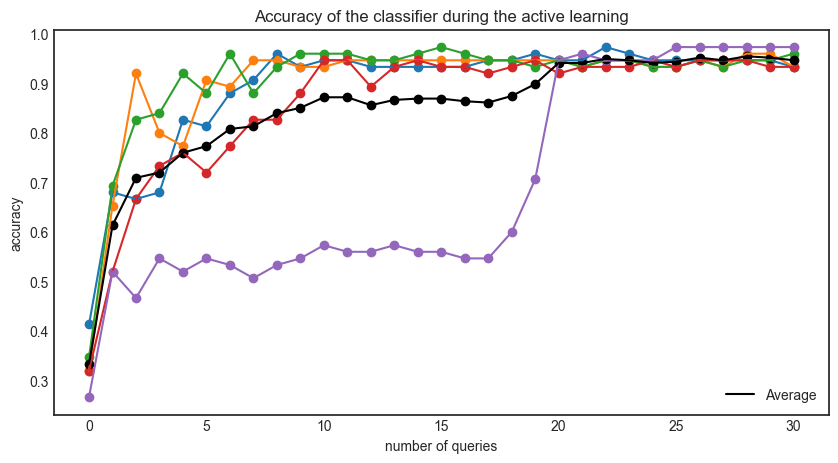

In [136]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')

    for i in range(len(total_scores)):
        to_plot = total_scores[i]
        plt.plot(range(n_queries+1), to_plot)
        plt.scatter(range(n_queries+1), to_plot)
    
    plt.plot(range(n_queries+1), average_scores, color="black", label="Average")
    plt.scatter(range(n_queries+1), average_scores, color="black")

    plt.legend(loc='lower right')
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()